In [1]:
"""The purpose of this document is to quickly analyze the main datapoints of a new test run csv file."""

from fcn import read_and_clean
import matplotlib.pyplot as plt
import pandas as pd
import streamlit as st

'''Identify which columns to keep in the dataset.'''
columns = [
        'Date_Time', 
        'Lat', 'Lon', 'Speed m/s', 'Distance km',
        'RPM 1', 'Motor Load 1 %', 'Motor Torque 1 %', 'Motor Temp 1 C',
        # 'RPM 2', 'Motor Load 2 %%', 'Motor Torque 2 %%', 'Motor Temp 2 C',
        # 'RPM 3', 'Motor Load 3 %%', 'Motor Torque 3 %%', 'Motor Temp 3 C',
        # 'RPM 4', 'Motor Load 4 %%', 'Motor Torque 4 %%', 'Motor Temp 4 C',
        # 'Depth m',
        # 'Temp Source 1', 'Temp 1 C',
        # 'Temp Source 2', 'Temp 2 C',
        # 'Temp Source 3', 'Temp 3 C',
        # 'Temp Source 4', 'Temp 4 C',
        'Pack Current 1 A', 'Pack Voltage 1 V', 'Pack Temp 1 C', 'SOC 1 %',
        # 'Pack Current 2 A', 'Pack Voltage 2 V', 'Pack Temp 2 C', 'SOC 2 %%',
        # 'Pack Current 3 A', 'Pack Voltage 3 V', 'Pack Temp 3 C', 'SOC 3 %%',
        # 'Pack Current 4 A', 'Pack Voltage 4 V', 'Pack Temp 4 C', 'SOC 4 %%'
        ]


In [57]:
file = "data/L230216.CSV"

df = read_and_clean(file)
# df = pd.read_csv(file)
df = df[columns][14000:18800]

# names = [0]
# for i in df.index:
#     if df['Lat'][i] == 'Lat':
#         names.append(i)
#     else: pass

# print(names)

# trips = {}
# cnt=0
# for i in names:
#     trips[cnt] = df.iloc[:i]
#     df = df.iloc[i+1:]
#     # print(trips[cnt], df.head())
#     cnt+=1

# trips[3]

/home/rtostrander/photon-range-estimator/fcn.py:8: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, nrows=n, parse_dates=[[0,1]])


Removed the following 2 rows with string values. 
 [269, 4539]


In [58]:
"""Function to loop through data and find individaul runs.
Criteria: SOC decreases and is not 0. Voltage is not zero. """

def find_runs(df):
    ind = []
    for i in df.index:
        if df['Pack Voltage 1 V'][i]<10:
            df.drop(i, inplace=True)
            continue
        elif df['Speed m/s'][i]>50:
            df.drop(i, inplace=True)
            continue
        elif df['SOC 1 %'][i]<5 or df['SOC 1 %'][i]>100:
            df.drop(i, inplace=True)
            continue
        # elif df['SOC 1 %'][i] < df['SOC 1 %'][i+1]:
            
        #     continue
        else:
            ind.append(i)
            pass
    
    # run = []
    # for i in ind:

    #     if ind[i+1]-ind[i]==1:
    #         run.append(ind[i])
            
    #     elif len(run)>600:
    #         print(run[0],run[-1])
    #         run=[]
    #         continue

    return ind

# ind = find_runs(df)

def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return [(s, e+1) for s, e in zip(edges, edges)]

# ranges(ind)

# df2 = find_runs(df)

# df = df.iloc[list]
# df.head()

In [59]:
"""Totals: Distance, Time, Battery Consumed"""

df['Power'] = df['Pack Current 1 A']*df['Pack Voltage 1 V']*10/1000

batt_cap = 63   # kWh
batt_health = 1.00 # %
batt_full = batt_cap*batt_health
nm_conversion = 0.539957

batt_consumed = (df['SOC 1 %'].iloc[0] - df['SOC 1 %'].iloc[-1])*batt_full/100   # kWh
dist_traveled = (df['Distance km'].iloc[-1] - df['Distance km'].iloc[0])*nm_conversion  # nm [1km = 0.539957nm]
time_spent = df['Date_Time'].iloc[-1] - df['Date_Time'].iloc[0]
avg_consumption_rate = dist_traveled/batt_consumed
avg_power = batt_consumed/time_spent.total_seconds()*3600
print('Run Stats:', round(time_spent.total_seconds()/60, 2), 'min |', 
      round(dist_traveled, 2), 'nm traveled |', 
      batt_consumed, 'kWh spent |', 
      round(avg_consumption_rate, 3), 'nm/kWh')

print('Speed [m/s]: Avg', round(df['Speed m/s'].mean(),2), '| Max', round(df['Speed m/s'].max(), 2))
print('Power [kW]: Avg', round(df['Power'].mean(), 2), 'kW | Max ', round(df['Power'].max(), 2), 'kW')
print('Avg kW', round(df['Power'].mean(),2), '| Battery spend/time', avg_power, 'kWh/h')

Run Stats: 80.25 min | 5.25 nm traveled | 12.6 kWh spent | 0.417 nm/kWh
Speed [m/s]: Avg 3.93 | Max 7.15
Power [kW]: Avg 9.15 kW | Max  22.08 kW
Avg kW 9.15 | Battery spend/time 9.42056074766355 kWh/h


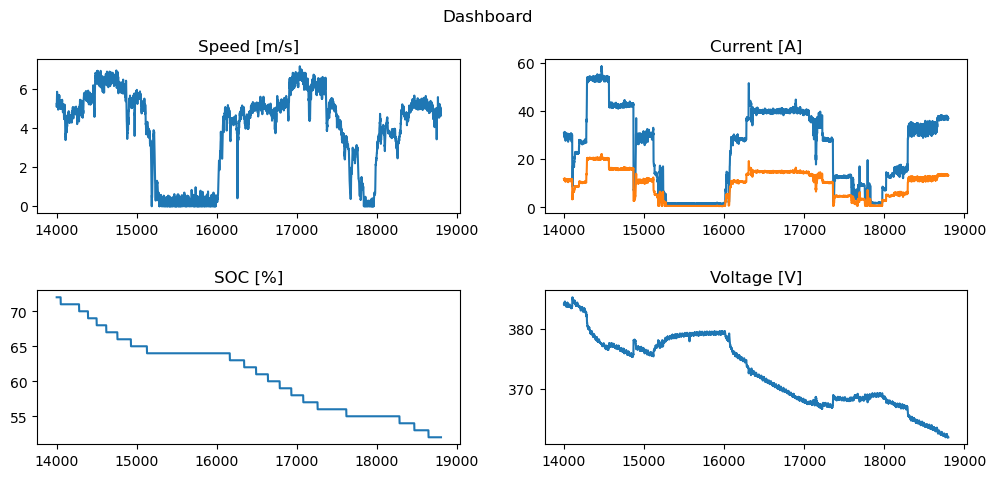

In [60]:
"""Plots: Speed, Amps, ... vs. Time"""

# df2 = df.iloc[14000:18800]
# df2.reset_index(inplace=True)
df2 = df

plt.figure(figsize = (12,5))
plt.suptitle('Dashboard')

plt.subplot(2,2,1)
plt.title('Speed [m/s]')
plt.plot(df2.index, df2['Speed m/s'])

plt.subplot(2,2,2)
plt.title('Current [A]')
plt.plot(df2.index, df2['Pack Current 1 A'], df2['Power'])

plt.subplots_adjust(hspace = 0.5)

plt.subplot(2,2,3)
plt.title('SOC [%]')
plt.plot(df2.index, df2['SOC 1 %'])

plt.subplot(2,2,4)
plt.title('Voltage [V]')
plt.plot(df2.index, df2['Pack Voltage 1 V']*10)
